Electricity_Load_Forecasting using LSTM (Long Short Term Memory) For '07-12-2020' to '20-12-2020'

In [ ]:
#Importing Dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping


print(tf.__version__)


2.4.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
Dataset = pd.read_excel("/content/drive/MyDrive/Colab_files/Train_20201207.xlsx")
Dataset.to_csv('train_20201102.csv')
Dataset.head()

# We copy the dataset such that we do not loose the original dataset
Original_Dataset = Dataset.copy()
Original_Dataset.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Time,Date,NEM Demand(Actual)
0,00:30,2020-12-07,5484.1
1,01:00,2020-12-07,5366.4
2,01:30,2020-12-07,5282.0
3,02:00,2020-12-07,5201.6
4,02:30,2020-12-07,5155.9


In [ ]:
Dataset ['DateTime'] = Dataset['Date'].astype(str) + " "+ Dataset['Time'].astype(str)
Dataset.tail()
Dataset ['Date'] = pd.to_datetime(Dataset['Date'], format = '%Y-%m-%d')
Dataset.tail()
Dataset ['DateTime'] = pd.to_datetime(Dataset['DateTime'], format = '%Y-%m-%d %H:%M:%S')
Dataset.tail()
Dataset.dtypes
Dataset.tail(229)


,Time,Date,NEM Demand(Actual),DateTime
443,06:00,2020-12-16,5265.0,2020-12-16 06:00:00
444,06:30,2020-12-16,5429.1,2020-12-16 06:30:00
445,07:00,2020-12-16,5606.1,2020-12-16 07:00:00
446,07:30,2020-12-16,5778.8,2020-12-16 07:30:00
447,08:00,2020-12-16,5982.5,2020-12-16 08:00:00
...,...,...,...,...
667,22:00,2020-12-20,5901.6,2020-12-20 22:00:00
668,22:30,2020-12-20,5765.2,2020-12-20 22:30:00
669,23:00,2020-12-20,5683.3,2020-12-20 23:00:00
670,23:30,2020-12-20,5563.0,2020-12-20 23:30:00


DateTime
2020-12-07 00:30:00    5484.1
2020-12-07 01:00:00    5366.4
2020-12-07 01:30:00    5282.0
2020-12-07 02:00:00    5201.6
2020-12-07 02:30:00    5155.9
Name: NEM Demand(Actual), dtype: float64


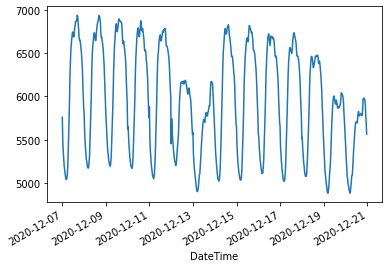

In [ ]:
#Plot the dataset
plot_features = Dataset['NEM Demand(Actual)']
plot_features.index = Dataset['DateTime']
_= plot_features.plot(subplots = True)
print(plot_features.head())

In [ ]:
Dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
NEM Demand(Actual),672.0,5971.323661,609.974163,4877.7,5383.2,5980.1,6554.125,6942.8


In [ ]:
cols = ['NEM Demand(Actual)']
Dataset_actual = Dataset[cols]
print(Dataset_actual.dtypes)
print(Dataset_actual.shape)
Dataset_actual.columns

NEM Demand(Actual)    float64
dtype: object
(672, 1)


Index(['NEM Demand(Actual)'], dtype='object')

In [ ]:
#Dataset_actual = Dataset_actual.values
Dataset_actual = Dataset_actual.astype('float32')
Dataset_actual.shape
Dataset_actual.head()

(672, 1)

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1)) 
Dataset_actual = scaler.fit_transform(Dataset_actual)

In [ ]:
train_size = int(len(Dataset_actual) * 0.66)
test_size = len(Dataset_actual) - train_size
train, test = Dataset_actual[0:train_size,:], Dataset_actual[train_size:len(Dataset_actual),:]


In [ ]:
train1 = pd.DataFrame(train)
test1 = pd.DataFrame(test)
print(train_size, test_size)


443 229


In [ ]:
def to_sequences(Dataset_actual, seq_size=1):
    x = []
    y = []

    for i in range(len(Dataset_actual)-seq_size-1):
        #print(i)
        window = Dataset_actual[i:(i+seq_size), 0]
        x.append(window)
        y.append(Dataset_actual[i+seq_size, 0])
        
    return np.array(x),np.array(y)
    

In [ ]:
seq_size = 10  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.

trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)



print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))

print(trainX.shape, train.shape)

Shape of training set: (432, 10)
Shape of test set: (218, 10)
(432, 10) (443, 1)


In [ ]:
# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
print('Single LSTM with hidden Dense...')
model = Sequential()
model.add(LSTM(64,input_shape =(None, seq_size), return_sequences=False))
model.add(Dense(64))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


model.summary()


Single LSTM with hidden Dense...
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 64)                19200     
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 23,425
Trainable params: 23,425
Non-trainable params: 0
_________________________________________________________________


In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, verbose=2, mode='auto', restore_best_weights=True)
model.fit(trainX, trainY, validation_data=(testX, testY),
          verbose=2, epochs=50, callbacks = monitor)


Epoch 1/50
14/14 - 2s - loss: 0.1863 - val_loss: 0.0312
Epoch 2/50
14/14 - 0s - loss: 0.0480 - val_loss: 0.0250
Epoch 3/50
14/14 - 0s - loss: 0.0301 - val_loss: 0.0188
Epoch 4/50
14/14 - 0s - loss: 0.0221 - val_loss: 0.0165
Epoch 5/50
14/14 - 0s - loss: 0.0155 - val_loss: 0.0099
Epoch 6/50
14/14 - 0s - loss: 0.0100 - val_loss: 0.0065
Epoch 7/50
14/14 - 0s - loss: 0.0060 - val_loss: 0.0046
Epoch 8/50
14/14 - 0s - loss: 0.0041 - val_loss: 0.0034
Epoch 9/50
14/14 - 0s - loss: 0.0035 - val_loss: 0.0033
Epoch 10/50
14/14 - 0s - loss: 0.0034 - val_loss: 0.0031
Epoch 11/50
14/14 - 0s - loss: 0.0033 - val_loss: 0.0031
Epoch 12/50
14/14 - 0s - loss: 0.0032 - val_loss: 0.0028
Epoch 13/50
14/14 - 0s - loss: 0.0031 - val_loss: 0.0031
Epoch 14/50
14/14 - 0s - loss: 0.0030 - val_loss: 0.0028
Epoch 15/50
14/14 - 0s - loss: 0.0027 - val_loss: 0.0026
Epoch 16/50
14/14 - 0s - loss: 0.0025 - val_loss: 0.0025
Epoch 17/50
14/14 - 0s - loss: 0.0025 - val_loss: 0.0023
Epoch 18/50
14/14 - 0s - loss: 0.0023 - 

In [ ]:
# make predictions

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


In [ ]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])



In [ ]:
test = scaler.inverse_transform(test)

In [ ]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 61.72 RMSE
Test Score: 65.61 RMSE


In [ ]:
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(Dataset_actual)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(Dataset_actual)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(Dataset_actual)-1, :] = testPredict

testp= np.empty_like(Dataset_actual)
testp[:, :] = np.nan
testp[len(trainPredict)+(seq_size*2)+1:len(Dataset_actual)-1, :] = test[11:]



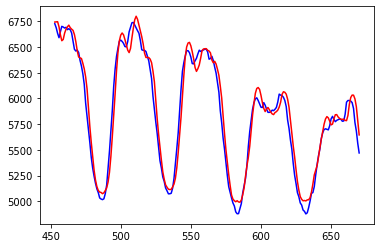

In [ ]:
# plot baseline and predictions
#plt.plot(scaler.inverse_transform(Dataset_actual), color= 'red', label = 'Original')
plt.plot(testp, color = 'blue', label = 'test_dataset')
#plt.plot(trainPredictPlot, color = 'blue', label = 'Prediction_on_traindataset')
plt.plot(testPredictPlot, color = 'red', label = 'Prediction_on_testdataset')
plt.show()
